In [53]:
import pymad8 as _m8
import matplotlib.pyplot as _plt
import numpy as _np
import pandas as _pd
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [73]:
tw0 = _m8.Output("../../01_mad8/XFEL_T20/beam_size/TWISS_CL_T20_ALPH_0")
tw1 = _m8.Output("../../01_mad8/XFEL_T20/beam_size/TWISS_CL_T20_ALPH_1")
tw2 = _m8.Output("../../01_mad8/XFEL_T20/beam_size/TWISS_CL_T20_ALPH_2")
tw3 = _m8.Output("../../01_mad8/XFEL_T20/beam_size/TWISS_CL_T20_ALPH_3")
tw4 = _m8.Output("../../01_mad8/XFEL_T20/beam_size/TWISS_CL_T20_ALPH_4")
tw5 = _m8.Output("../../01_mad8/XFEL_T20/beam_size/TWISS_CL_T20_ALPH_5")
twM1 = _m8.Output("../../01_mad8/XFEL_T20/beam_size/TWISS_CL_T20_ALPH_M1")
twM2 = _m8.Output("../../01_mad8/XFEL_T20/beam_size/TWISS_CL_T20_ALPH_M2")
twM3 = _m8.Output("../../01_mad8/XFEL_T20/beam_size/TWISS_CL_T20_ALPH_M3")
twM4 = _m8.Output("../../01_mad8/XFEL_T20/beam_size/TWISS_CL_T20_ALPH_M4")
twM5 = _m8.Output("../../01_mad8/XFEL_T20/beam_size/TWISS_CL_T20_ALPH_M5")
twisslist = [tw0, tw1, tw2, tw3, tw4, tw5, twM1, twM2, twM3, twM4, twM5]

Mad8.readTwissFile > nrec=878
Mad8.readTwissFile > nrec=878
Mad8.readTwissFile > nrec=878
Mad8.readTwissFile > nrec=878
Mad8.readTwissFile > nrec=878
Mad8.readTwissFile > nrec=878
Mad8.readTwissFile > nrec=878
Mad8.readTwissFile > nrec=878
Mad8.readTwissFile > nrec=878
Mad8.readTwissFile > nrec=878
Mad8.readTwissFile > nrec=878


In [74]:
for tw in twisslist:
    tw.calcBeamSize(3.58e-11, 3.58e-11, 1e-6)

Text(0, 0.5, 'sigmaX [m]')

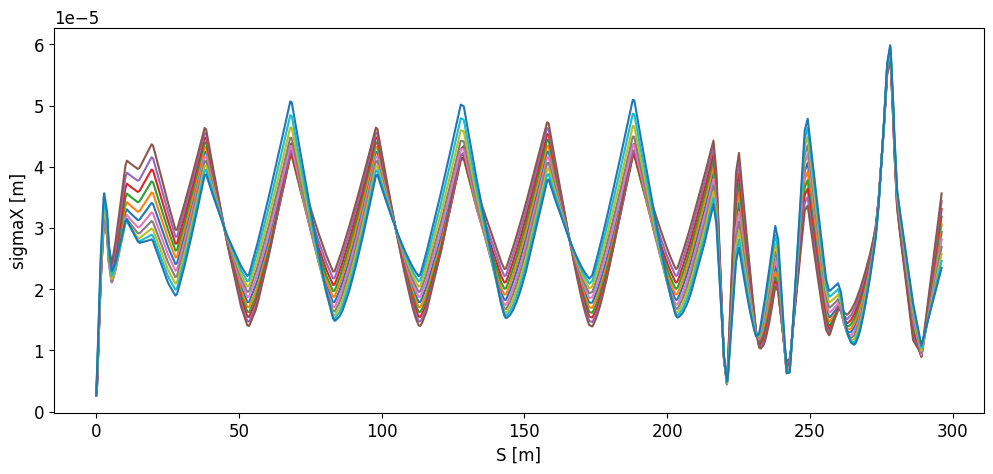

In [75]:
_plt.figure(figsize=(12,5))
for tw in twisslist:
    S = tw.data[['S']].values.flatten()
    SX = tw.data[['SIGX']].values.flatten()
    _plt.plot(S, SX)
#_plt.legend()
_plt.xlabel("S [m]")
_plt.ylabel("sigmaX [m]")

In [38]:
def getMADdataInDF(twisslist):
    nbbeam = len(twisslist)
    S = twisslist[0].data[['S']].values.flatten()
    bpmlist = twisslist[0].data[['NAME']].values.flatten()
    nbbpm = len(bpmlist)
    
    data_dict = {'SIGX': [], 'SIGXP': [], 'SIGY': [], 'SIGYP': [], 'S': []}
    for tw in twisslist:
        for coord in data_dict.keys():
            values = tw.data[[coord]].values.flatten()
            data_dict[coord].append(values)
            
    for key in data_dict:
        data_dict[key] = _np.asarray(data_dict[key]).flatten()
    df = _pd.DataFrame(data_dict, index=_pd.MultiIndex.from_product([range(s) for s in (nbbeam, nbbpm)], names=['Beam', 'BPM']))
    #df.index.set_levels([bpmlist], level=[1], inplace=True)
    return df

In [76]:
df1 = getMADdataInDF([tw0, tw1, tw2])
df2 = getMADdataInDF([tw0, tw1, tw2, tw3, tw4])
df3 = getMADdataInDF([tw0, tw1, tw2, tw3, tw4, tw5, twM1, twM2, twM3, twM4, twM5])

In [77]:
df3

SIGX     SIGXP      SIGY     SIGYP           S
Beam BPM                                                    
0    0    0.000003  0.000013  0.000010  0.000003    0.000000
     1    0.000004  0.000014  0.000010  0.000004    0.266050
     2    0.000004  0.000014  0.000010  0.000004    0.266050
     3    0.000004  0.000014  0.000010  0.000004    0.266050
     4    0.000006  0.000014  0.000010  0.000004    0.375000
...            ...       ...       ...       ...         ...
10   873  0.000011  0.000004  0.000009  0.000004  289.058631
     874  0.000011  0.000004  0.000009  0.000004  289.058631
     875  0.000023  0.000004  0.000029  0.000004  296.148630
     876  0.000023  0.000004  0.000029  0.000004  296.148630
     877  0.000023  0.000004  0.000029  0.000004  296.148630

[9658 rows x 5 columns]

In [42]:
def buildPositionMatrix(df_reduced, coord):
    nb_beams = df_reduced.index.levshape[0]
    M = df_reduced[coord].to_numpy().reshape((-1, nb_beams)).transpose()
    return M


def buildMatrixAndVectorForSVD(df, refbpmname, coord='SIGX'):
    df_ref = df.loc[df.index.get_level_values('BPM') == refbpmname][['SIGX', 'SIGY']]
    df_matrix = df.loc[df.index.get_level_values('BPM') != refbpmname][['SIGX', 'SIGY']]

    M_X = buildPositionMatrix(df_matrix, 'SIGX')
    M_Y = buildPositionMatrix(df_matrix, 'SIGY')
    Vect_ref = df_ref[coord].to_numpy()
    M = _np.concatenate((M_X, M_Y), axis=1)

    M = M - M.mean(0)

    return Vect_ref, M


def SVD(M):
    U, d, V_t = _np.linalg.svd(M, full_matrices=False)
    D = _np.diag(d)

    D_i = _np.linalg.inv(D)
    U_t = U.transpose()
    V = V_t.transpose()

    return U, D, V_t, U_t, D_i, V


def calcCoeffsWithSVD(M, ref_Vect):
    U, d, V_t = _np.linalg.svd(M, full_matrices=False)
    D = _np.diag(d)

    D_i = _np.linalg.inv(D)
    U_t = U.transpose()
    V = V_t.transpose()

    C = _np.dot(_np.dot(V, _np.dot(D_i, U_t)), ref_Vect)
    return C


def calcMeasuredPositionAndNResidual(M, ref_Vect):
    C = calcCoeffsWithSVD(M, ref_Vect)
    meas_Vect = _np.dot(M, C)
    Residual = ref_Vect - _np.dot(M, C)

    return meas_Vect, Residual


def calcJitterAndNoise(df, coord):
    Jitter = _np.array([])
    Noise = _np.array([])
    for bpm in df.index.get_level_values(0).unique():
        V, M = buildMatrixAndVectorForSVD(df, bpm, coord=coord)
        meas_Vect, Residual = calcMeasuredPositionAndNResidual(M, V)
        Jitter = _np.append(Jitter, meas_Vect.std())
        Noise = _np.append(Noise, Residual.std())

    return Jitter, Noise

In [167]:
def CalcCorrelChi2(df, sampler_name, ref_sampler_name, coord, ref_coord):
    V = df.loc[df.index.get_level_values('BPM') == sampler_name][[coord]].to_numpy().flatten()
    ref_V = df.loc[df.index.get_level_values('BPM') == ref_sampler_name][[ref_coord]].to_numpy().flatten()

    def linear(x, a, b):
        return a * x + b

    popt, pcov = curve_fit(linear, V, ref_V)
    slope, cst = popt
    err = sum((ref_V - slope * V - cst) ** 2)

    return err, slope, cst


def getChi2(df, coord, ref_bpm, ref_coord):
    S = _np.array([])
    Vect_Chi2 = _np.array([])
    nbbpm = len(df.index.get_level_values('BPM').unique())

    for i, bpm in enumerate(df.index.get_level_values('BPM').unique()):
        S = _np.append(S, df.loc[df.index.get_level_values('BPM') == bpm][['S']].to_numpy().flatten()[0])
        Vect_Chi2 = _np.append(Vect_Chi2, CalcCorrelChi2(df, bpm, ref_bpm, coord, ref_coord)[0])

    Curve_Chi2 = interp1d(S, Vect_Chi2, fill_value="extrapolate")
    return S, Curve_Chi2

def PlotTheoryFitAndChi2(df, coord, ref_bpm, ref_coord, indicators=None, xlim=None):

    S, Curve_Chi2_bdsim = getChi2(df, coord, ref_bpm, ref_coord)
    _plt.plot(S, Curve_Chi2_bdsim(S), ls='', color='C3', marker='+', label='$\chi^2$ for ${{{c}}}$ from MAD8'.format(c=ref_coord))

    ax.axvline(df.loc[df.index.get_level_values('BPM') == ref_bpm][['S']].to_numpy().flatten()[0], ls='--', color='C2', label='Reference Sampler')

    if indicators:
        for bpm in indicators:
            ax.axvline(df.loc[df.index.get_level_values('BPM') == bpm][['S']].to_numpy().flatten()[0], 
                       ls='--', color='C1')
    
    if xlim:
        _plt.xlim(xlim)
    _plt.ylabel('$\chi^2$')
    _plt.xlabel('$s$ [m]')
    _plt.legend()
    
def plotOptions(figsize=[9, 6], rows_colums=[1, 1], height_ratios=None, sharex=False, sharey=False, font_size=17):
    _plt.rcParams['font.size'] = font_size
    if height_ratios is not None:
        fig, ax = _plt.subplots(rows_colums[0], rows_colums[1], figsize=(figsize[0], figsize[1]),
                                gridspec_kw={'height_ratios': height_ratios}, sharex=sharex, sharey=sharey)
    else:
        fig, ax = _plt.subplots(rows_colums[0], rows_colums[1], figsize=(figsize[0], figsize[1]),
                                sharex=sharex, sharey=sharey)
    fig.tight_layout()
    return fig, ax

def PlotCorrelation(df, bpm, coord, ref_bpm, ref_coord, figsize=[9, 9]):
    fig, ax = plotOptions(figsize=figsize, rows_colums=[1, 1], sharex=False, height_ratios=None, font_size=12)

    V = df.loc[df.index.get_level_values('BPM') == bpm][[coord]].to_numpy().flatten()
    ref_V = df.loc[df.index.get_level_values('BPM') == ref_bpm][[ref_coord]].to_numpy().flatten()

    _plt.plot(V, ref_V, ls='', marker='+', color='C0', label='BDSIM data')

    err, slope, cst = CalcCorrelChi2(df, bpm, ref_bpm, coord, ref_coord)
    _plt.plot(V, slope * V + cst, color='C2', label='Fit: $\chi^2$ = {}'.format(err))

    _plt.ticklabel_format(axis="x", style="sci", scilimits=(-6, 0))
    _plt.xlabel("{} [m]".format(coord))
    _plt.ylabel("{}_ref [m]".format(ref_coord))
    _plt.legend()

Mad8.readTwissFile > nrec=878


(0.0, 395.0)

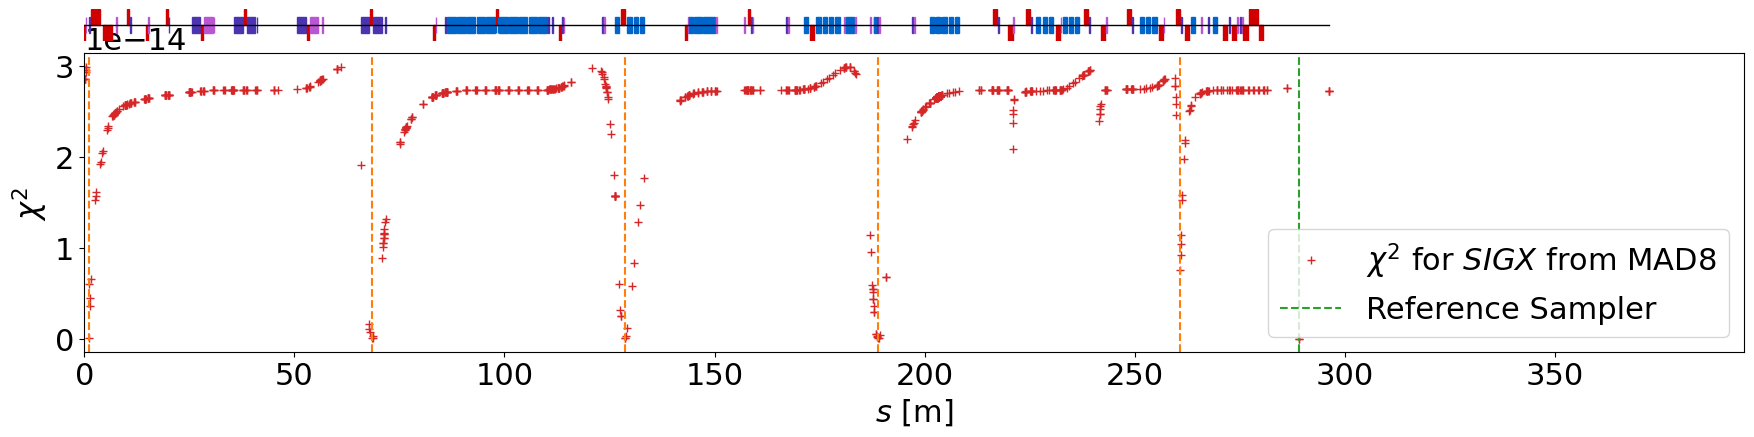

In [196]:
tw = _m8.Output("../../01_mad8/XFEL_T20/TWISS_CL_T20")
_plt.rcParams['font.size'] = 22
fig, ax = _plt.subplots(1,1,figsize=(18,5))
fig.tight_layout()
PlotTheoryFitAndChi2(df2, 'SIGX', 874, 'SIGX', indicators=[8, 155, 321, 449, 813])
_m8.Plot.AddMachineLatticeToFigure(fig, tw)
_plt.xlim(0, 395)

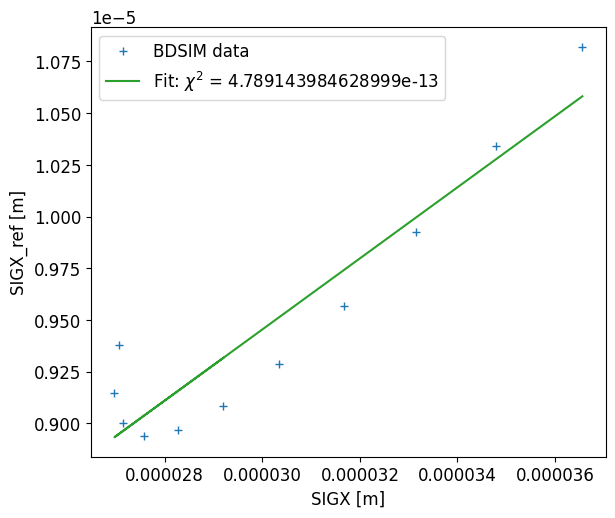

In [132]:
PlotCorrelation(df3, 425, 'SIGX', 874, 'SIGX', figsize=[6,5])

In [158]:
def buildBPMmatrix(df, refbpm, ref_coord, noise=None):
    ref_Vect, M = buildMatrixAndVectorForSVD(df, refbpm, coord = ref_coord)
    
    reduced_df = df.drop(df.index[df.index.get_level_values('BPM') == refbpm])
    S_Vect = reduced_df.loc[reduced_df.index.get_level_values('Beam') == 0][['S']].to_numpy().flatten()

    if noise is not None:
        M_noise = _np.random.normal(0, noise, M.shape)
        M = M + M_noise

    return M, ref_Vect, S_Vect

def PlotSVDCoeff(df, refbpm, ref_coord='SIGX', noise=10e-6, figsize=[14, 6]):
    fig, ax = plotOptions(figsize=figsize, rows_colums=[1, 1], sharex=False, height_ratios=None)
    
    M, ref_vect, S_vect = buildBPMmatrix(df, refbpm, ref_coord, noise=noise)
    C_vect = calcCoeffsWithSVD(M, ref_vect)
    C_X, C_Y = _np.split(C_vect, 2)
    _plt.plot(S_vect, _np.abs(C_X), '+-', color='C0', markersize=15, markeredgewidth=2, label='$|c_x|$ from Mad8')
    _plt.plot(S_vect, _np.abs(C_Y), '+-', color='C1', markersize=15, markeredgewidth=2, label='$|c_y|$ from Mad8')

    _plt.axvline(df.loc[df.index.get_level_values('BPM') == refbpm][['S']].to_numpy().flatten()[0], ls='--', color='C2', label='Reference Sampler')
    _plt.ylabel('$|c_x|$ / $|c_y|$')
    _plt.xlabel('$s$ [m]')
    _plt.legend()

def CalcResolution(df, ref_coord, refbpm, noise=10e-6):
    M, Real_vect, S_vect = buildBPMmatrix(df, refbpm, ref_coord, noise=noise)
    C_vect = calcCoeffsWithSVD(M, Real_vect)

    Meas_vect = _np.dot(M, C_vect)
    Res_array = Meas_vect - Real_vect
    return Res_array

def PlotResolution(df, ref_coord, refbpm, noise=10e-6, bins=50, color="C0"):

    Res = CalcResolution(df, ref_coord, refbpm, noise=noise)
    _plt.hist(Res, bins=bins, histtype='step', color=color,
              label='$R_{{{c}}}$ = {:1.3f} $\\mu${} from Mad8'.format(_np.std(Res)*1e6, 'm', c=ref_coord))

    _plt.xlabel('${}_{{{m}}}-{}_{{{t}}}$ [{}]'.format(ref_coord, ref_coord, 'm', m='IP,meas', t='IP,track'))
    _plt.ylabel('Number of Events')
    _plt.legend()

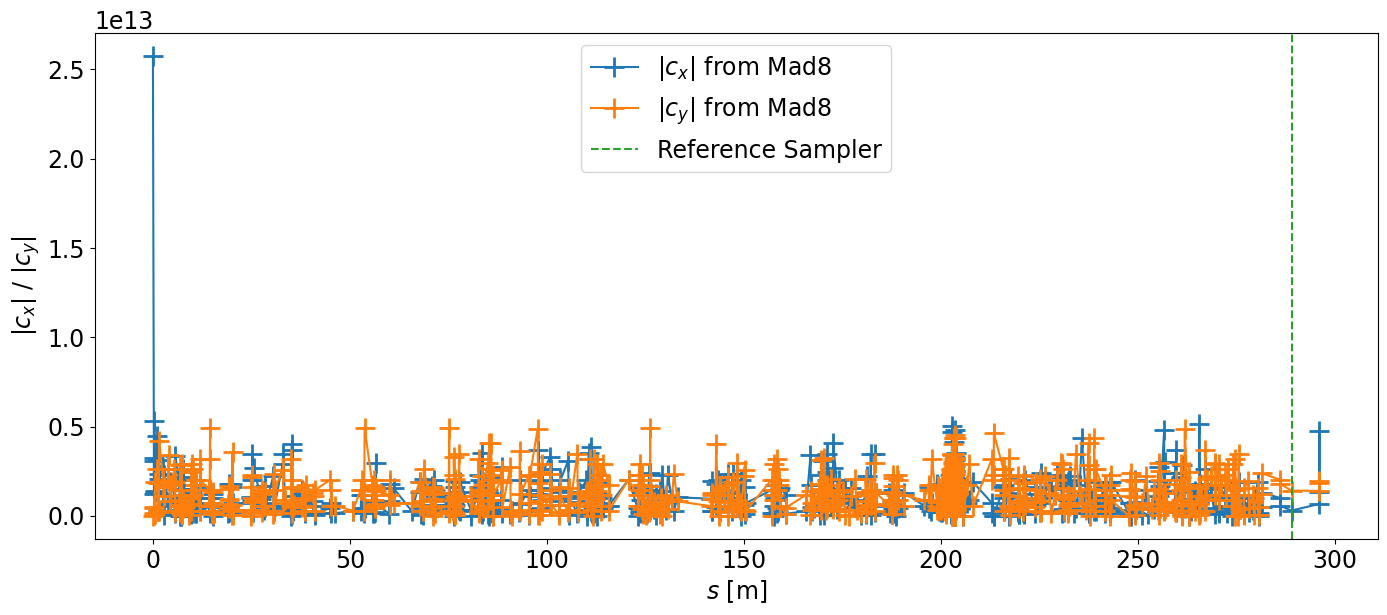

In [159]:
PlotSVDCoeff(df3, 874, ref_coord='SIGX', noise=0e-6)

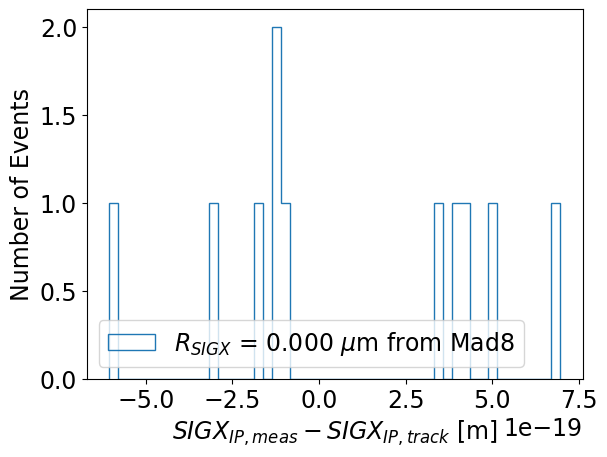

In [163]:
PlotResolution(df3, 'SIGX', 874, noise=0.01e-6)

In [152]:
df3.drop(df3.index[df3.index.get_level_values('BPM') == 874])

SIGX     SIGXP      SIGY     SIGYP           S
Beam BPM                                                    
0    0    0.000003  0.000013  0.000010  0.000003    0.000000
     1    0.000004  0.000014  0.000010  0.000004    0.266050
     2    0.000004  0.000014  0.000010  0.000004    0.266050
     3    0.000004  0.000014  0.000010  0.000004    0.266050
     4    0.000006  0.000014  0.000010  0.000004    0.375000
...            ...       ...       ...       ...         ...
10   872  0.000018  0.000004  0.000015  0.000004  286.168630
     873  0.000011  0.000004  0.000009  0.000004  289.058631
     875  0.000023  0.000004  0.000029  0.000004  296.148630
     876  0.000023  0.000004  0.000029  0.000004  296.148630
     877  0.000023  0.000004  0.000029  0.000004  296.148630

[9647 rows x 5 columns]